In [1]:
import numpy as np
import glio
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import h5py as h5
import pandas as pd

In [2]:
#This function uses glio to load the particle data from the Gadget files 
#Recieves the number of the snapshot to load and the directory where the snapshots are located
#Returns the particles properties and the time of the snapshot
def load_particles( n_snapshot, input_dir):
    file_name = input_dir + f'snapshot_{n_snapshot:03}'
    print( 'Loading file: ', file_name )
    file = glio.GadgetSnapshot( file_name )
    file.load()
    head = file.header
    box_size = head.BoxSize
    current_z = head.redshift
    particle_type = 1                                   #Select dark matter particles (1) 
    positions = file.pos[particle_type]                 #Positions of dark matter particles
    mass = file.mass[particle_type]   * 1e10            #Mass of dark matter particles in Msolar
    positions_all = positions.transpose()                
    pos_z = positions_all[0]
    pos_y = positions_all[1]
    pos_x = positions_all[2]
#     velocities = file.vel[particle_type]                 #Velocities of dark matter particles
#     velocities_all = velocities.transpose()
#     vel_z = velocities_all[0]
#     vel_y = velocities_all[1]
#     vel_x = velocities_all[2]
    
    return mass, pos_x, pos_y, pos_z, current_z

In [3]:
def plot_particles( depth, pos_x, pos_y, pos_z, output_directory):
    indxs = np.where( pos_z < depth)            #Select only the particles with z<depth
    pos_x_small = pos_x[indxs]                  #positions X of selected particles
    pos_y_small = pos_y[indxs]                  #positions Y of selected particles

    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    axis = plt.gca()
    axis.set_xlim(0, 100000)
    axis.set_ylim(0, 100000)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    axis.scatter( pos_x_small, pos_y_small, s=0.002)   #Plot points for the particles 
    image_name = f'particles_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )

In [4]:
def get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz ):
    dx = Lbox / nx
    dy = Lbox / ny
    dz = Lbox / nz
    dvol = dx * dy * dz
    density = np.zeros( [nx, ny, nz])

    indxs_x = ( pos_x / dx ).astype(np.int)
    indxs_y = ( pos_y / dy ).astype(np.int)
    indxs_z = ( pos_z / dz ).astype(np.int)

    total_particles = len( mass )

    for n_particle in range( total_particles ):
        indx_x = indxs_x[n_particle]
        indx_y = indxs_y[n_particle]
        indx_z = indxs_z[n_particle]
        part_mass = mass[n_particle]
        density[indx_z, indx_y, indx_x ] += part_mass

    density = density / dvol
    return density

In [5]:
def plot_density( density, Lbox, output_directory ):
       
    density_proj = density.sum( axis=0)

    image_name = output_directory + f'density_{n_snapshot:03}.png'
    fig = plt.figure(0)
    fig.clf()
    fig.set_size_inches(20,20)
    plt.tight_layout()
    fig.set_size_inches(20,20)
    axis = plt.gca()
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    divider = make_axes_locatable(axis)
    cax = divider.append_axes("right", size="3%", pad=0.05)
    colorbar = fig.colorbar( image, cax=cax )
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    fig.axes[0].get_yaxis().set_visible(False)
    fig.axes[0].get_xaxis().set_visible(False)
    fig.savefig(image_name,  pad_inches=0,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )


In [6]:
def plot_particles_and_density( n_slices, Lbox, density, pos_x, pos_y, output_directory  ):
    depth = n_slices * dz

    indxs = np.where( pos_z < depth)           
    pos_x_small = pos_x[indxs]                 
    pos_y_small = pos_y[indxs]
    pos_y_small = Lbox - pos_y_small 

    dens = density[0:n_slices, :, :]

    fig, axis_list = plt.subplots(nrows=1, ncols=2, figsize=(40,20),  subplot_kw={'aspect': 1})
    plt.subplots_adjust( wspace=0.01)

    axis = axis_list[0]
    image = axis.scatter( pos_x_small, pos_y_small, s=0.002) 
    axis.set_xlim(0, Lbox)
    axis.set_ylim(0, Lbox)
    axis.set_title( "Dark Matter Particles", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)



    density_proj = dens.sum( axis=0)
    axis = axis_list[1]
    image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
    axis.set_title( "Dark Matter Density", fontsize=40)
    axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
    colorbar = fig.colorbar(image, ax=axis_list, shrink=0.85, pad=0.01)
    colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
    image_name = f'part_dens_{n_snapshot}.png'
    fig.savefig( output_directory + image_name,  pad_inches=0.1,  bbox_inches='tight', dpi=100 ) #Save the image
    print( "Saved image: ", output_directory + image_name )  


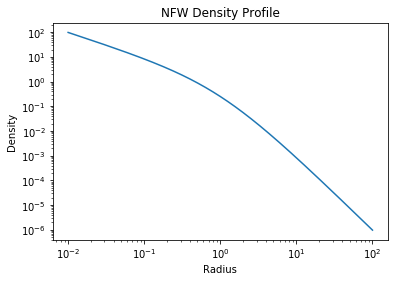

In [74]:
#Plot NFW density profile
#NFW density profile
rho_0 = 1
r_0 = 1
r = np.linspace( 0.01, 100, 10000)
density = rho_0 / (  (r/r_0) * ( 1+ r/r_0)**2 )
plt.loglog( r,  density)
plt.xlabel('Radius')
plt.ylabel('Density')
plt.title("NFW Density Profile")
plt.savefig('nfw_dens.png')

In [67]:
def plot_halo_mass_function( h_mass, Lbox, output_directory, nBins=40):
    fig = plt.figure(0)
    ax = plt.gca() #Get curren axes
    mass_log = np.log10( h_mass )
    hist, bin_edges = np.histogram( mass_log, bins=nBins )
    bin_centers = (bin_edges[:-1] + bin_edges[1:])/2
    # plt.plot(  bin_centers, np.log10(hist) )
    n_total = hist.sum()
    hist_cumul = ( n_total - hist.cumsum() ) / Lbox**3
    ax.plot(  bin_centers, np.log10(hist_cumul) )
    ax.set_xlabel(r'log Mass $[{\rm h^{-1} M_{\odot}}]$', fontsize=15 )
    ax.set_ylabel(r'log n(>M)  $[h^3{\rm Mpc^{-3}}]$', fontsize=15 )
    ax.set_title('Cumulative Halo Mass function', fontsize=15)
    fig.savefig( output_directory + 'halo_mass.function.png', bbox_inches='tight')



/usr/local/anaconda352/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in log10
  # Remove the CWD from sys.path while we load stuff.


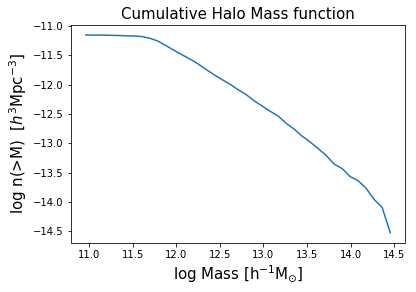

In [68]:
# Load halo catalog and plot Halo Mass Function
n_snapshot = 200
output_directory = 'images/particles_density/'
halos_dir = 'data/halo_catalogs_128/'
halos_file = halos_dir + f'halos_{n_snapshot:03}.ascii'

#Load Halo catalog
halos_data = pd.read_csv( halos_file, sep=' ')

#Get Halo Mass
halos_mass = halos_data['mvir']
plot_halo_mass_function( halos_mass, Lbox, output_directory, nBins=40)



In [ ]:
# Load Particles anf plot particles and density
input_dir = 'data/128_dm_halos/'
output_directory = 'images/particles_density/'

nx = 128
ny = 128
nz = 128

Lbox = 100000 #kpc
dz = Lbox / nz

n_snapshot = 200
for n_snapshot in range( 201):
    mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
    density = get_density( mass, pos_x, pos_y, pos_z, Lbox, nx, ny, nz )


    n_slices = 128
    plot_particles_and_density( n_slices, Lbox, density, pos_x, pos_y, output_directory  )




Loading file:  data/128_dm_halos/snapshot_000
Saved image:  images/particles_density/part_dens_0.png
Loading file:  data/128_dm_halos/snapshot_001
Saved image:  images/particles_density/part_dens_1.png
Loading file:  data/128_dm_halos/snapshot_002
Saved image:  images/particles_density/part_dens_2.png
Loading file:  data/128_dm_halos/snapshot_003
Saved image:  images/particles_density/part_dens_3.png
Loading file:  data/128_dm_halos/snapshot_004
Saved image:  images/particles_density/part_dens_4.png
Loading file:  data/128_dm_halos/snapshot_005
Saved image:  images/particles_density/part_dens_5.png
Loading file:  data/128_dm_halos/snapshot_006
Saved image:  images/particles_density/part_dens_6.png
Loading file:  data/128_dm_halos/snapshot_007
Saved image:  images/particles_density/part_dens_7.png
Loading file:  data/128_dm_halos/snapshot_008


In [10]:
#Load Halos Positions 
halos_dir = 'data/halo_catalogs_128/'
halos_file = halos_dir + f'halos_{n_snapshot:03}.ascii'

halos_data = pd.read_csv( halos_file, sep=' ')
x = halos_data['x'] * 1e3
y = halos_data['y'] * 1e3 
z = halos_data['z'] * 1e3
r = halos_data['rvir'] 
mass = halos_data['mbound_vir']
indxs = mass > 2e12
x = x[indxs].values
y = y[indxs].values
z = z[indxs].values
r = r[indxs].values
nHalos = len( x )
# x.as_matrix()

Saved image:  images/particles_density/part_dens_200.png


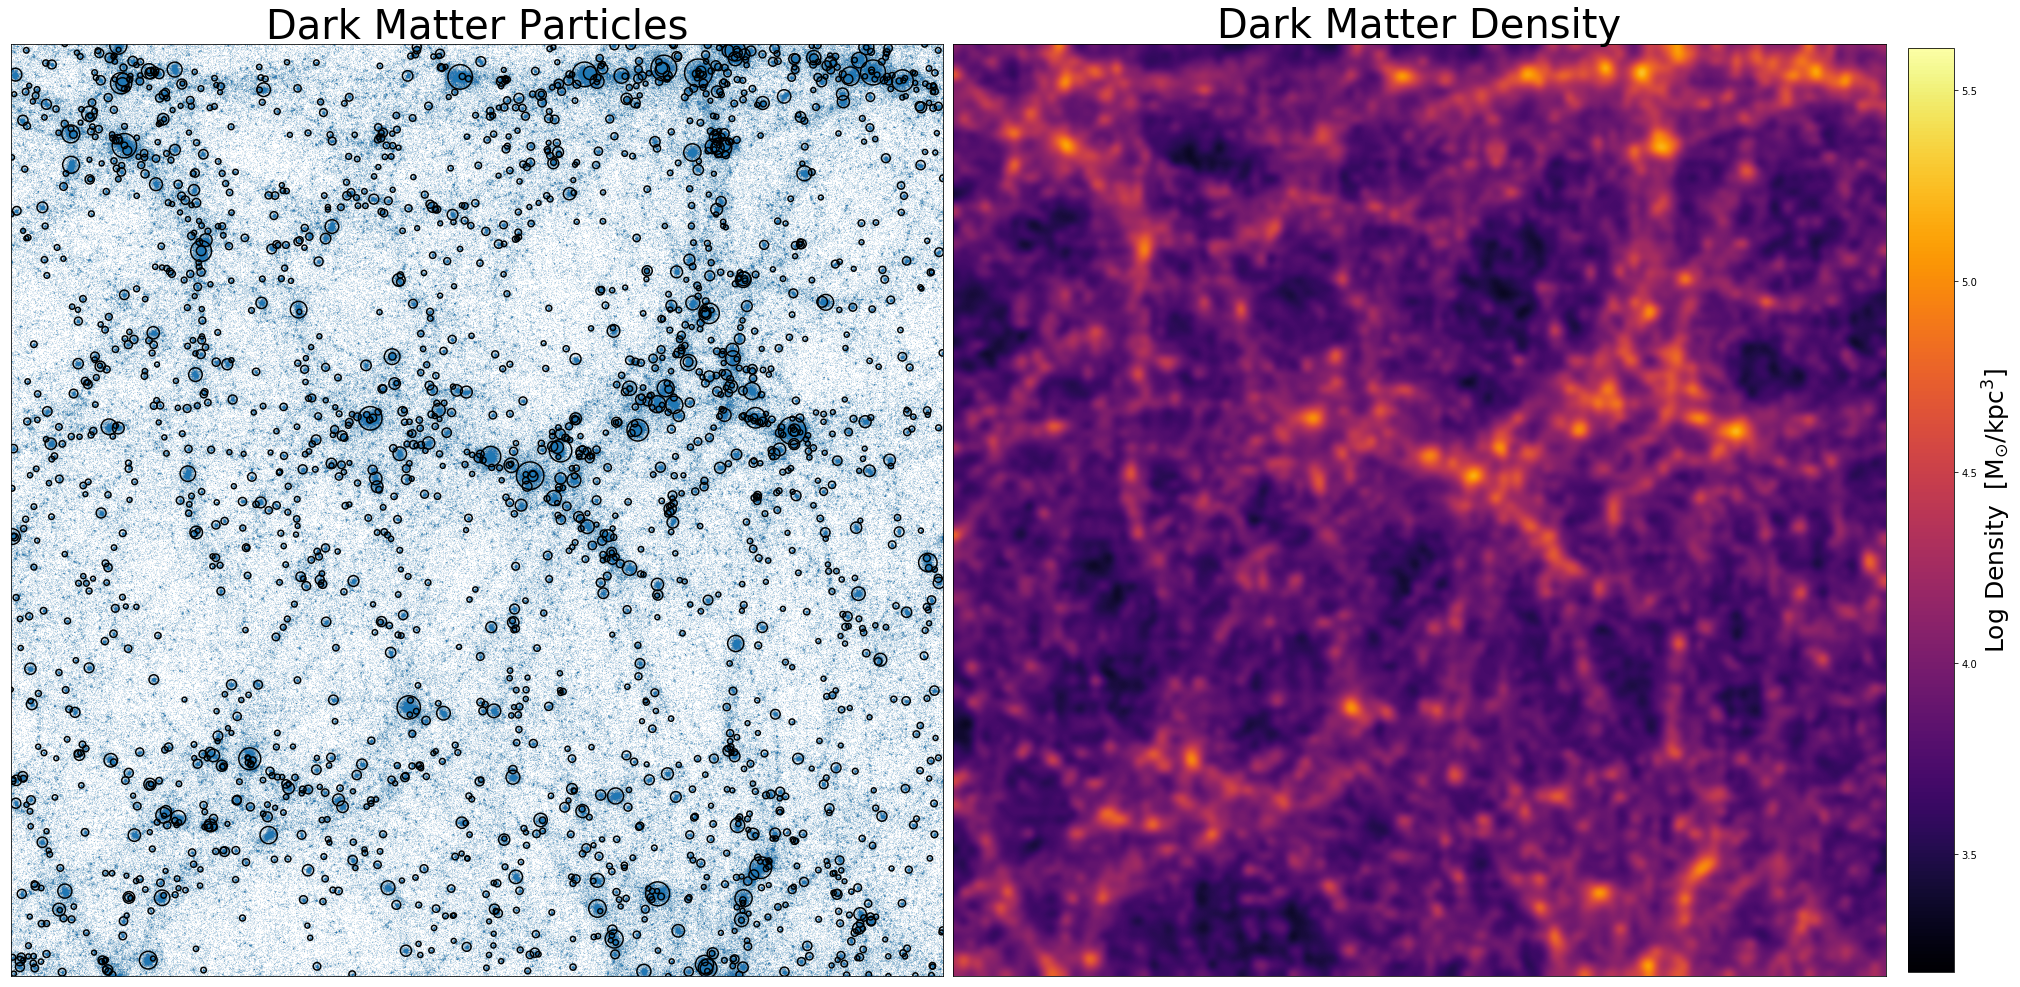

In [11]:
#Plot Halos Positions
from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

depth = n_slices * dz

indxs = np.where( pos_z < depth)           
pos_x_small = pos_x[indxs]                 
pos_y_small = pos_y[indxs]
pos_y_small = Lbox - pos_y_small 

dens = density[0:n_slices, :, :]

fig, axis_list = plt.subplots(nrows=1, ncols=2, figsize=(40,20),  subplot_kw={'aspect': 1})
plt.subplots_adjust( wspace=0.01)

axis = axis_list[0]
image = axis.scatter( pos_x_small, pos_y_small, s=0.002) 
circles = [ Circle( (z[i], Lbox - y[i]), r[i],) for i in range(nHalos) ]
p = PatchCollection(circles, facecolors='none', edgecolors='k', linewidth=1.5, alpha=1 )
axis.add_collection(p)
axis.set_xlim(0, Lbox)
axis.set_ylim(0, Lbox)
axis.set_title( "Dark Matter Particles", fontsize=40)
axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)



density_proj = dens.sum( axis=0)
axis = axis_list[1]
image = axis.imshow( np.log10(density_proj),extent=[0,Lbox, 0, Lbox], interpolation='bicubic', cmap='inferno' )
axis.set_title( "Dark Matter Density", fontsize=40)
axis.tick_params(axis='both', which='both', bottom=False, labelbottom=False, left=False, labelleft=False)
colorbar = fig.colorbar(image, ax=axis_list, shrink=0.85, pad=0.01)
colorbar.set_label(r'Log Density  $ [\mathrm{M}_{\odot} / \mathrm{kpc}^3] $', fontsize=25)
image_name = f'part_dens_{n_snapshot}.png'
fig.savefig( output_directory + image_name,  pad_inches=0.1,  bbox_inches='tight', dpi=100 ) #Save the image
print( "Saved image: ", output_directory + image_name )  


In [ ]:
# input_dir = 'data/128_dm/'
# output_directory = 'images/'
# depth = 100000 

# #Loop over all the snapshots.
# #For each snapshot load the particles data and plot the positions
# for n_snapshot in range(0,201):
#     mass, pos_x, pos_y, pos_z, current_z = load_particles( n_snapshot, input_dir)
#     plot_particles( depth, pos_x, pos_y, pos_z, output_directory)
